# Validation of Trained All IBD Fatigue ML Model on Scottish Data

Validation data provided by Dr Clara Ramos, Dr Solomon Ong, Dr Pete Cartlidge

In [1]:
import pandas as pd
import pickle

from src.config.paths import (
    DNN_DIR,
    BENCHMARKING_DIR,
    SKLEARN_DIR,
    VALIDATION_SCOTLAND_DIR,
    ensure_output_dirs,
)
from src.data.loading import load_sklearn_models_and_metadata, load_dnn_model
from src.data.validation import (
    preprocess_validation_data,
    evaluate_model,
    prepare_logreg_data,
    plot_roc_curve,
    plot_confusion_matrix,
    create_metrics_dict,
    plot_combined_roc_curves,
    plot_model_agreement_heatmap,
)

ensure_output_dirs()

## Config

In [2]:
output_dir = VALIDATION_SCOTLAND_DIR
sklearn_models_dir = SKLEARN_DIR / "exports"

## Load Validation Data and Models

In [3]:
df = pd.read_excel(
    "data/fatigue_ml_data_validation_scotland.xlsx", sheet_name="fatigue_validation"
)
target_df = pd.read_csv(DNN_DIR / "exports" / "X_test.csv")

/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [4]:
# Load the model, scaler, and explainer
model, scaler, explainer = load_dnn_model(model_date="2025-04-24")

/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Load all sklearn models
print("Loading scikit-learn models...")
sklearn_models, sklearn_scaler, sklearn_feature_names = (
    load_sklearn_models_and_metadata(sklearn_models_dir)
)

Loading scikit-learn models...


In [6]:
# Load the logistic regression model
try:
    with open(BENCHMARKING_DIR / "statsmodels_logreg.pkl", "rb") as f:
        logreg_model = pickle.load(f)
    logreg_loaded = True
except FileNotFoundError:
    print("Warning: Logistic regression model file not found.")
    logreg_loaded = False
except Exception as e:
    print(f"Error loading or predicting with logistic regression model: {e}")
    logreg_loaded = False

In [7]:
# Preprocess data
X_scotland, y_scotland = preprocess_validation_data(df, target_df, scaler, country="scotland")

## Check Validation Data Matches Input Data

In [8]:
# Verify feature compatibility
sklearn_features_set = set(sklearn_feature_names)
scotland_features_set = set(X_scotland.columns)
if missing := (sklearn_features_set - scotland_features_set):
    print(f"Warning: Missing features in Scottish data: {missing}")
if extra := (scotland_features_set - sklearn_features_set):
    print(f"Warning: Extra features in Scottish data: {extra}")

print(
    f"Loaded {len(sklearn_models)} sklearn models: {', '.join(sklearn_models.keys())}"
)

Loaded 6 sklearn models: Svc, Mlpclassifier, Xgboost, Random Forest, Adaboost, Logistic Regression


In [9]:
X_scotland_columns_not_in_target_df = set(X_scotland.columns) - set(target_df.columns)
print(f"Columns in X_scotland not in target_df: {X_scotland_columns_not_in_target_df}")

target_df_columns_not_in_X_scotland = set(target_df.columns) - set(X_scotland.columns)
print(f"Columns in target_df not in X_scotland: {target_df_columns_not_in_X_scotland}")

Columns in X_scotland not in target_df: set()
Columns in target_df not in X_scotland: set()


## Initialise Results Container

In [10]:
all_model_results = {}

## Evaluating DNN Model

In [ ]:
# Evaluate model
y_pred_proba, y_pred, roc_auc, fpr, tpr, cm, metrics_dnn = evaluate_model(
    X_scotland, y_scotland, model
)

# Save results
all_model_results["Deep Neural Network"] = {
    "fpr": fpr,
    "tpr": tpr,
    "auc": roc_auc,
    "confusion_matrix": cm,
    "metrics": metrics_dnn,
    "predictions": y_pred,
    "probabilities": y_pred_proba,
    "color": "darkorange",
}

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


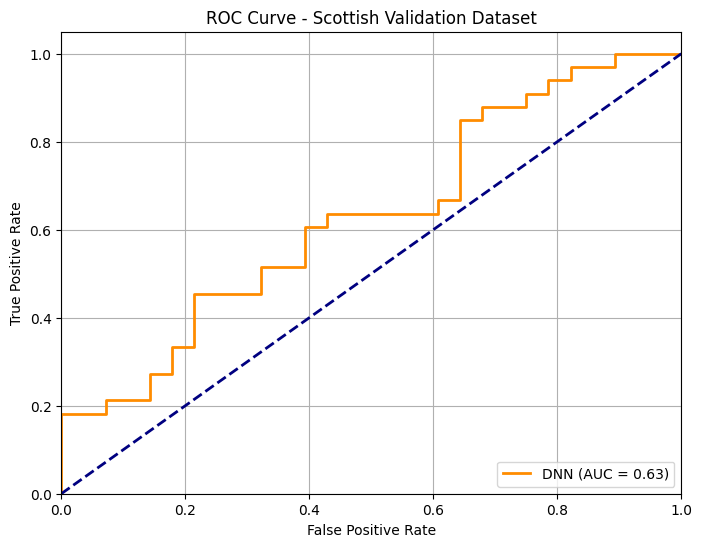

In [12]:
plot_roc_curve(
    fpr,
    tpr,
    roc_auc,
    title="ROC Curve - Scottish Validation Dataset",
    save_path=output_dir / "roc_curve_scotland.png",
)

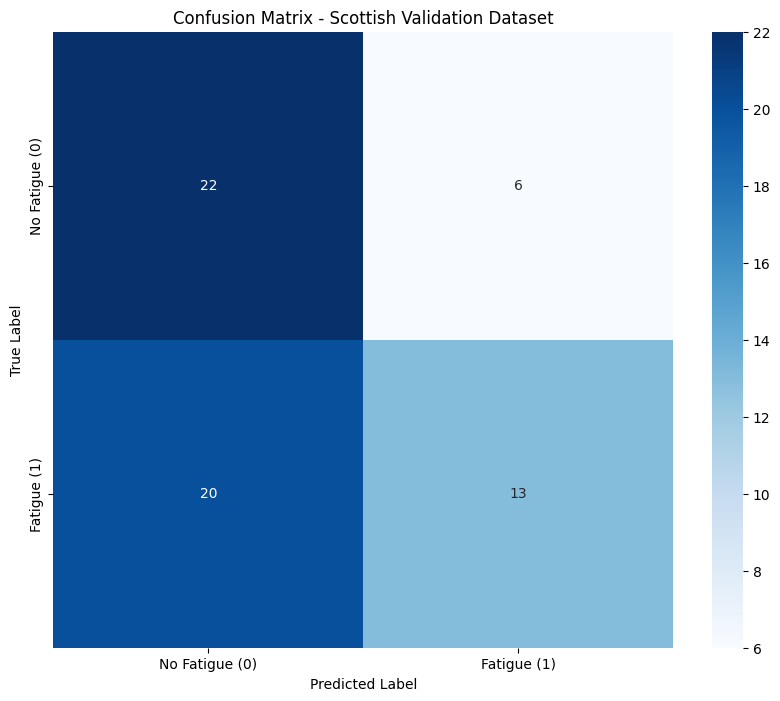

In [13]:
plot_confusion_matrix(
    cm,
    title="Confusion Matrix - Scottish Validation Dataset",
    save_path=output_dir / "confusion_matrix_scotland.png",
)

## Evaluating Logistic Regression Model

In [14]:
if logreg_loaded:
    X_scotland_const = prepare_logreg_data(X_scotland, logreg_model)
    (
        y_pred_proba_logreg,
        y_pred_logreg,
        roc_auc_logreg,
        fpr_logreg,
        tpr_logreg,
        cm_logreg,
        metrics_logreg,
    ) = evaluate_model(X_scotland_const, y_scotland, logreg_model)

    all_model_results["Logistic Regression (statsmodels)"] = {
        "fpr": fpr_logreg,
        "tpr": tpr_logreg,
        "auc": roc_auc_logreg,
        "confusion_matrix": cm_logreg,
        "metrics": metrics_logreg,
        "predictions": y_pred_logreg,
        "probabilities": y_pred_proba_logreg,
        "color": "blue",
    }

## Evaluating SKLearn Models

In [15]:
for model_name, model in sklearn_models.items():
    print(f"Evaluating {model_name}...")
    (
        y_pred_proba_sklearn,
        y_pred_sklearn,
        roc_auc_sklearn,
        fpr_sklearn,
        tpr_sklearn,
        cm_sklearn,
        metrics_sklearn,
    ) = evaluate_model(X_scotland, y_scotland, model)

    # Save results
    all_model_results[model_name] = {
        "fpr": fpr_sklearn,
        "tpr": tpr_sklearn,
        "auc": roc_auc_sklearn,
        "confusion_matrix": cm_sklearn,
        "metrics": metrics_sklearn,
        "predictions": y_pred_sklearn,
        "probabilities": y_pred_proba_sklearn,
        "color": None,
    }

Evaluating Svc...
Evaluating Mlpclassifier...
Evaluating Xgboost...
Evaluating Random Forest...
Evaluating Adaboost...
Evaluating Logistic Regression...


## Calculate All Model Metrics

In [16]:
model_metrics = [
    create_metrics_dict(name, results["metrics"])
    for name, results in all_model_results.items()
]

# Create dataframe and sort by AUC
metrics_df = pd.DataFrame(model_metrics).sort_values("AUC", ascending=False)
metrics_df = metrics_df.round(3)

# Display metrics
print("Model Performance on Scottish Validation Dataset:")
print(metrics_df)

# Save metrics to CSV
metrics_df.to_csv(output_dir / "scotland_validation_metrics.csv", index=False)
print(f"Metrics saved to {output_dir / 'scotland_validation_metrics.csv'}")

Model Performance on Scottish Validation Dataset:
                               Model    AUC  Accuracy  Sensitivity  \
6                           Adaboost  0.668     0.492        0.182   
5                      Random Forest  0.655     0.590        0.364   
7                Logistic Regression  0.650     0.574        0.364   
3                      Mlpclassifier  0.647     0.557        0.333   
2                                Svc  0.640     0.541        0.394   
1  Logistic Regression (statsmodels)  0.639     0.557        0.364   
4                            Xgboost  0.633     0.607        0.394   
0                Deep Neural Network  0.630     0.574        0.394   

   Specificity  Positive Predictive Value  Negative Predictive Value  \
6        0.857                      0.600                      0.471   
5        0.857                      0.750                      0.533   
7        0.821                      0.706                      0.523   
3        0.821                 

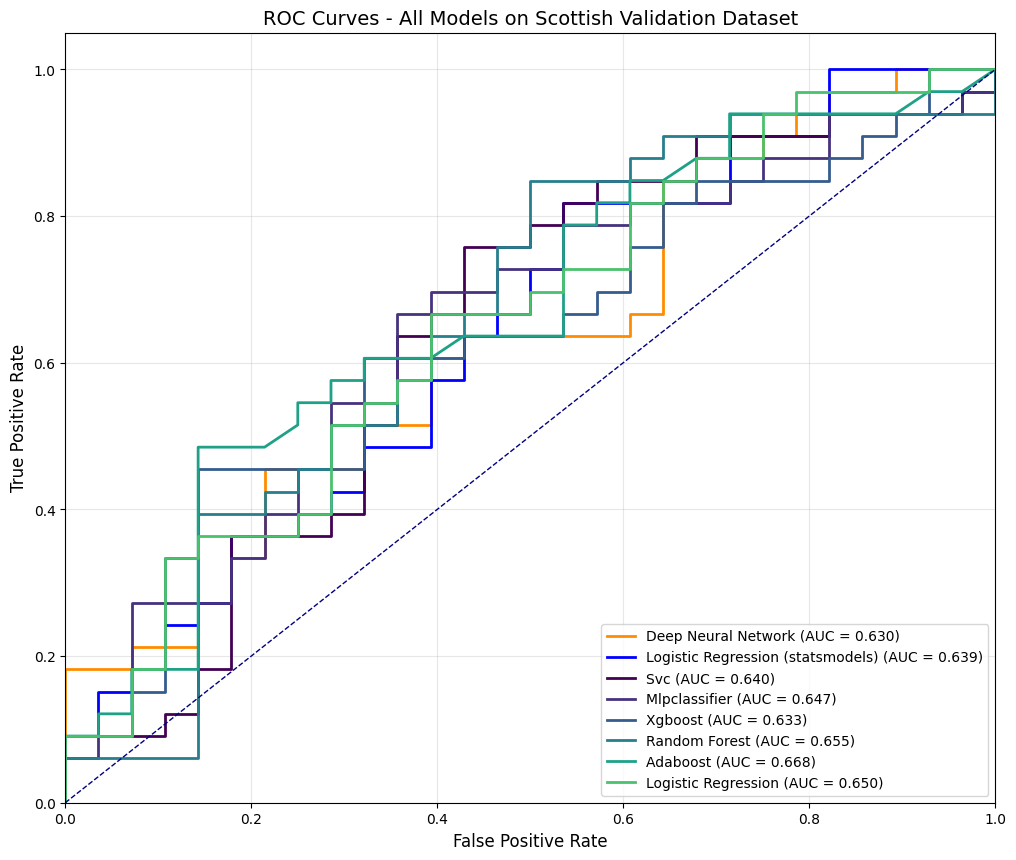

In [17]:
plot_combined_roc_curves(
    all_model_results=all_model_results,
    output_path=output_dir / "scotland_validation_roc_curves.png",
    title="ROC Curves - All Models on Scottish Validation Dataset",
)

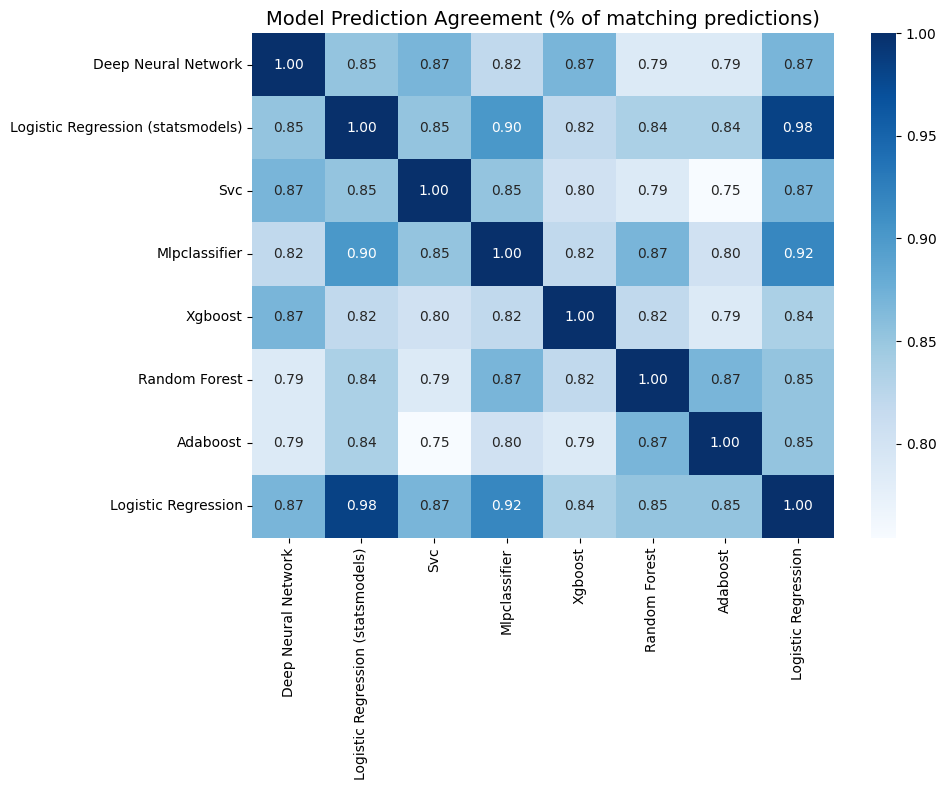

In [18]:
# Prepare the predictions dictionary
all_predictions = {}
for model_name, results in all_model_results.items():
    # Flatten predictions for the DNN model if needed
    if model_name == "Deep Neural Network":
        all_predictions[model_name] = results["predictions"].flatten()
    else:
        all_predictions[model_name] = results["predictions"]

# Call the function
plot_model_agreement_heatmap(
    all_predictions=all_predictions,
    output_path=output_dir / "scotland_validation_model_agreement.png",
    title="Model Prediction Agreement (% of matching predictions)",
)

## Interrogate Confusion Matrix (DNN Model)

In [19]:
# Create masks for each category based on actual and predicted values
# Need to flatten y_pred since it might have an extra dimension
y_pred_flat = y_pred.flatten()
true_positive_mask = (y_scotland == 1) & (y_pred_flat == 1)
true_negative_mask = (y_scotland == 0) & (y_pred_flat == 0)
false_positive_mask = (y_scotland == 0) & (y_pred_flat == 1)
false_negative_mask = (y_scotland == 1) & (y_pred_flat == 0)

# Create separate dataframes
tp_df = X_scotland[true_positive_mask].copy()
tn_df = X_scotland[true_negative_mask].copy()
fp_df = X_scotland[false_positive_mask].copy()
fn_df = X_scotland[false_negative_mask].copy()

# Verify the numbers match the confusion matrix
print("Dataset sizes:")
print(f"True Positives: {len(tp_df)}")
print(f"True Negatives: {len(tn_df)}")
print(f"False Positives: {len(fp_df)}")
print(f"False Negatives: {len(fn_df)}")

Dataset sizes:
True Positives: 13
True Negatives: 22
False Positives: 6
False Negatives: 20


100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


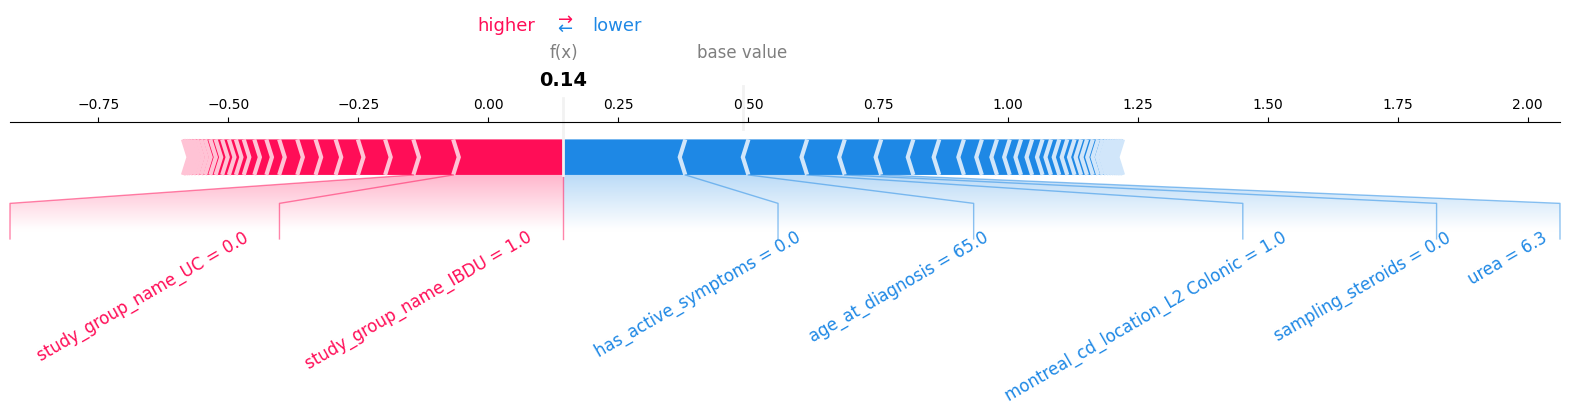

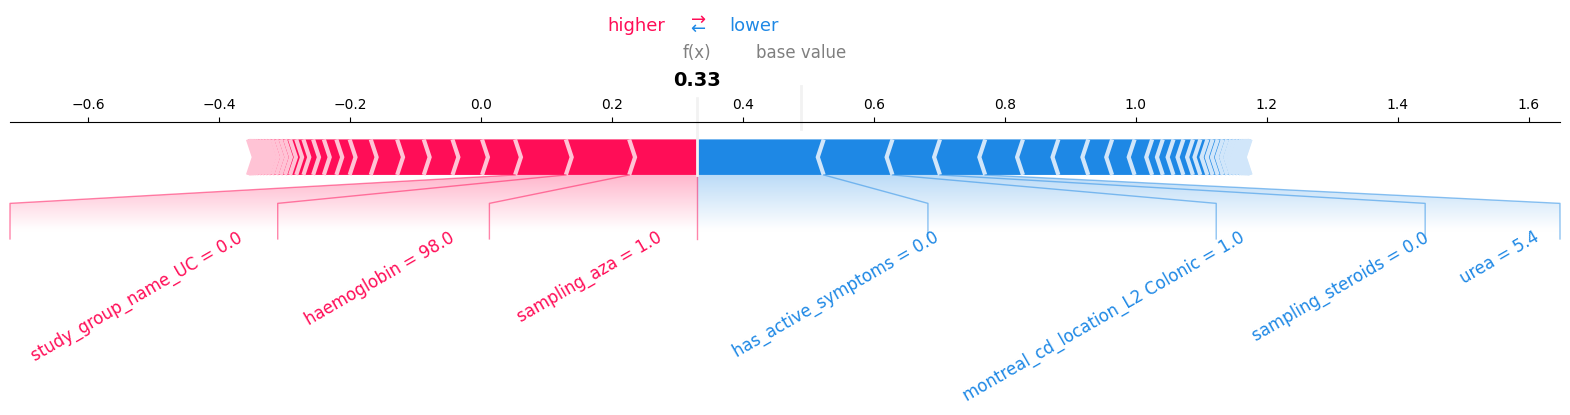

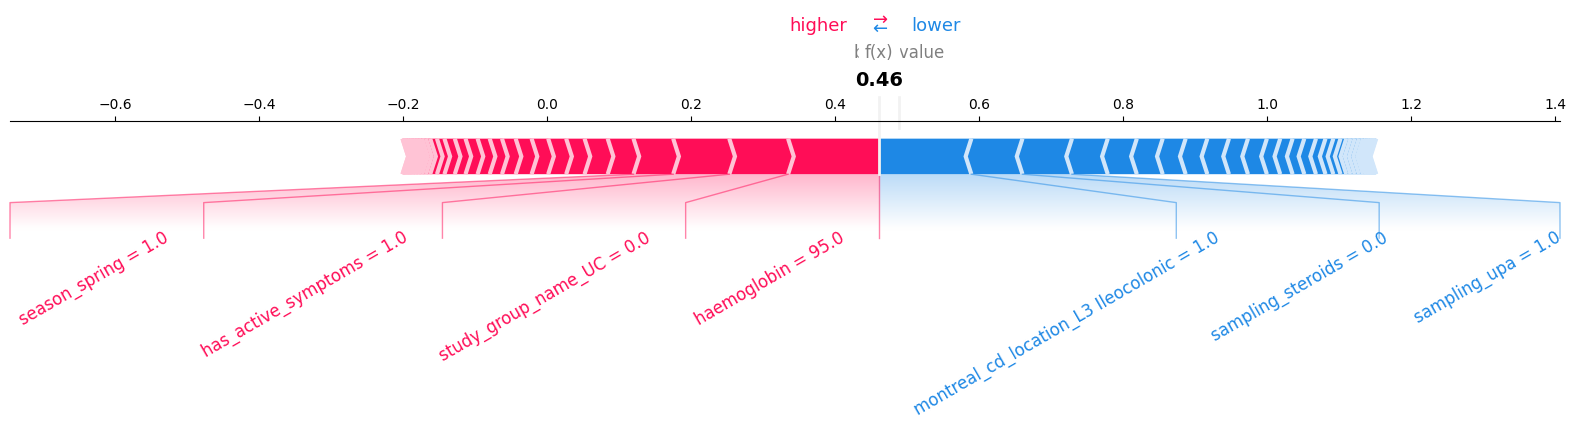

In [20]:
# Optional: Interrogate individual predictions
from src.data.validation import plot_shap_force_plot

plot_shap_force_plot(fn_df, scaler, explainer, max_plots=3)

## Export Preprocessed Validation Data for Combined Analysis

In [21]:
# Save X and y data for combining later
X_scotland.to_csv(output_dir / "X_scotland.csv", index=False)
pd.Series(y_scotland).to_csv(output_dir / "y_scotland.csv", index=False)
print(f"Saved preprocessed Scottish validation data to {output_dir}")

Saved preprocessed Scottish validation data to /Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/output/validation/scotland
